In [2]:
import numpy as np
import pandas as pd
import surprise
import matplotlib.pyplot as plt

In [3]:
#Class to trainsform the data (both train and test in CDF)

class cdfTransformer(object):
    
    transformerSeries = {}
    
    def __init__(self, useridcolname, itemidcolname, ratingcolname):
        self.userid_colname = useridcolname
        self.itemid_colname = itemidcolname
        self.rating_colname = ratingcolname
    
    def getLowerOrEqualIndex(self,playtimeList, playtime):
        if playtime < playtimeList[0]:
            return 0
        ans = 0
        low = 0
        high = len(playtimeList) - 1
        while(low<=high):
            mid = low + (high-low)//2
            if playtime > playtimeList[mid]:
                ans = mid
                low = mid + 1
            elif playtime == playtimeList[mid]:
                return mid
            else:
                high = mid - 1
        return ans      
    
    def getNearestCdf(self,appid, playtime):
        playtimeList = self.transformerSeries[appid].index
        bestpos = self.getLowerOrEqualIndex(playtimeList, playtime)
        return self.transformerSeries[appid].iloc[bestpos]
    
    def fitTransform(self,tupledata):
        grouped1 = tupledata.groupby([self.itemid_colname,self.rating_colname]).count()
        grouped2 = grouped1.groupby(level=[0]).cumsum()
        grouped3 = grouped2.groupby(level = [0]).max()
        withcdf = grouped2/grouped3
        self.transformerSeries = pd.Series(withcdf[self.userid_colname],index=withcdf.index)
        withcdf_df = withcdf.reset_index(level=[0,1])
        withcdf_df.rename(columns={self.userid_colname:'temp_rating'}, inplace=True)
        finaltuple = pd.merge(withcdf_df,tupledata, on=[self.itemid_colname,self.rating_colname],how='inner',suffixes=('_newdf',''))
        finaltuple.drop(self.rating_colname, inplace=True, axis = 1)
        finaltuple.rename(columns={'temp_rating':self.rating_colname}, inplace=True)
        return finaltuple

    def Transform(self,tupledata):
        ansdata = tupledata.groupby([self.itemid_colname,self.rating_colname]).count().reset_index()
        ansdata.drop(self.userid_colname, inplace = True, axis = 1)
        ansdata['rating_temp'] =  ansdata.apply(lambda x: self.getNearestCdf(x[self.itemid_colname],x[self.rating_colname]), axis = 1)
        ansdata = pd.merge(ansdata,tupledata, on=[self.itemid_colname,self.rating_colname],how='inner',suffixes=('_newdf',''))
        ansdata.drop(self.rating_colname, axis = 1, inplace = True)
        ansdata.rename(columns = {"rating_temp":self.rating_colname}, inplace = True)         
        return ansdata

In [4]:
def constructCodes(df) :
    """
    Maps 'steamid' to categorical code 'sid'
    Maps 'appid' to categorical code 'aid'
    Returns :
        1. Dataframe with columns 'sid', 'aid', 'playtime_forever'
        2. Dictionary mapping 'steamid' to 'sid'
        3. Dictionary mapping 'sid' to 'steamid'
        4. Dictionary mapping 'appid' to 'aid'
        5. Dictionary mapping 'aid' to 'appid'
    """
    coded_df = df.copy(deep = True)
    coded_df["steamid"] = coded_df["steamid"].astype("category")
    coded_df["appid"] = coded_df["appid"].astype("category")
    coded_df["sid"] = coded_df["steamid"].cat.codes
    coded_df["aid"] = coded_df["appid"].cat.codes
    
    sid_to_steamid = dict(enumerate(coded_df["steamid"].cat.categories))
    aid_to_appid = dict(enumerate(coded_df["appid"].cat.categories))
    steamid_to_sid = {v : k for k, v in sid_to_steamid.items()}
    appid_to_aid = {v : k for k, v in aid_to_appid.items()}
    
    coded_df.drop(["steamid", "appid"], axis = 1, inplace = True)
    
    return(coded_df, steamid_to_sid, sid_to_steamid, appid_to_aid, aid_to_appid)

In [5]:
def getSplit(df, train_size, validation_size) :
    """
    Returns Train, Validation and Test DataFrames
    """
    train = df.copy(deep = True)
    val = df.copy(deep = True)
    test = df.copy(deep = True)
    
    assert train_size + validation_size < 1, "train_size + validation_size should be less than 1"
    test_size = 1 - train_size - validation_size
    
    test_sample = df.groupby("sid").apply(lambda x : x.sample(frac = test_size))
    test_sample.reset_index(level = 0, drop = True, inplace = True)
    test_idx = test_sample.index
    train.drop(test_idx, inplace = True)
    val.drop(test_idx, inplace = True)
    
    val_sample = train.groupby("sid").apply(lambda x : x.sample(frac = validation_size / (1 - test_size)))
    val_sample.reset_index(level = 0, drop = True, inplace = True)
    val_idx = val_sample.index
    train.drop(val_idx, inplace = True)
    
    assert train["sid"].nunique() == df["sid"].nunique()
    assert val["sid"].nunique() == df["sid"].nunique()

    #Contingency if any appids don't make it to train and val
    if train["aid"].nunique() != df["aid"].nunique() :
        missing_train_aid = list(set(df["aid"].unique()) - set(train["aid"].unique()))
        train_append = []
        for aid in missing_train_aid :
            train_append.append([0, 0, aid])
        train = train.append(pd.DataFrame(train_append, columns = ["playtime_forever", "sid", "aid"]), ignore_index = True)
    
    if val["aid"].nunique() != df["aid"].nunique() :
        missing_val_aid = list(set(df["aid"].unique()) - set(val["aid"].unique()))
        val_append = []
        for aid in missing_val_aid :
            val_append.append([0, 0, aid])
        val = val.append(pd.DataFrame(val_append, columns = ["playtime_forever", "sid", "aid"]), ignore_index = True)  
    
    return(train, val, test)

In [6]:
def train_test_split(dff, split_ratio = 0.8):
    
    tr_sample = dff.groupby('sid').apply(lambda x:x.sample(frac = 0.8))
    tr_sample_index = list(zip(*tr_sample.index))[1]
    te_sample = dff[(dff.index.isin(tr_sample_index) == False)]
    
    tr_sample.index.rename(['id', 'appid_level'], inplace=True)
    tr_sample.reset_index(drop = True, inplace = True)
    te_sample.reset_index(drop = True, inplace = True)
    
    return tr_sample, te_sample

In [7]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

Split the data on train -test and apply cdf transformation on both training and test data

In [12]:
df = pd.read_csv("data/final_data.csv", index_col = 0)
df_coded, steamid_to_sid, sid_to_steamid, appid_to_aid, aid_to_appid = constructCodes(df)
train, test = train_test_split(df_coded)
cdf = cdfTransformer("sid", "aid", "playtime_forever")
train = cdf.fitTransform(train)

/home/raghavjajodia/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [17]:
test = cdf.Transform(test)

In [22]:
train = train[['aid','sid','playtime_forever']]
test = test[['aid','sid','playtime_forever']]

In [25]:
reader = Reader(rating_scale = (0, 1))
data_train = Dataset.load_from_df(train, reader)

In [82]:
#Do cross validation with hyperparameter tuning on latentFactors

latentFactors = {10,20,50,100,70,80}
lrates = {0.001,0.005,0.01,0.05,0.1}
regparams = {0.02,0.1,0.002}

lfDict = {}

for lf in latentFactors:
    algo = surprise.SVD(n_factors=lf)
    results = cross_validate(algo, data_train, measures=['RMSE','MAE'], cv=2, verbose = True)
    lfDict[lf] = results

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2609  0.2611  0.2610  0.0001  
MAE (testset)     0.2172  0.2175  0.2174  0.0002  
Fit time          56.03   59.08   57.55   1.52    
Test time         17.05   14.72   15.89   1.16    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2608  0.2607  0.2607  0.0000  
MAE (testset)     0.2172  0.2170  0.2171  0.0001  
Fit time          53.29   55.50   54.40   1.11    
Test time         15.79   12.98   14.39   1.41    


In [34]:
f = open('continousSurprise_LatentFactorsAnal.txt','w')
for lf in lfDict:
    f.write(str(lf) + '  ' + str(lfDict[lf]) + '\n')
f.close()

In [60]:
plt.rc('font', family = "serif")
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

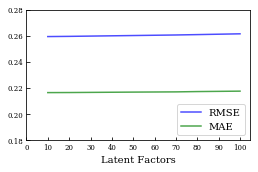

In [140]:
#plot the graph with rmse and mae on different latent factors

rmse_latentfac = [np.mean(lfDict[k]['test_rmse']) for k in list(lfDict.keys())]
mae_latentfac = [np.mean(lfDict[k]['test_mae']) for k in list(lfDict.keys())]
latentfac = [int(k) for k in lfDict.keys()]
latentfac = np.array(latentfac)
rmse_latentfac = np.array(rmse_latentfac)
mae_latentfac = np.array(mae_latentfac)

latentfacnew = latentfac[latentfac.argsort()]
rmse_latentfacnew = rmse_latentfac[latentfac.argsort()]
mae_latentfacnew = mae_latentfac[latentfac.argsort()]

fig, ax = plt.subplots(figsize = (4, 3))
ax.plot(latentfacnew, rmse_latentfacnew, alpha = 0.7, color = "blue", label = "RMSE")
ax.plot(latentfacnew, mae_latentfacnew, alpha = 0.7, color = "g", label = "MAE")
ax.set_xlabel('Latent Factors')
ax.tick_params(direction = "in")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.8])

ax.legend(loc='lower right')
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80,90, 100])
ax.set_yticks([0.18, 0.20, 0.22, 0.24, 0.26,0.28])
fig.savefig("LatentFacvsRmseMae_final_final.svg")
plt.show()

In [87]:
lratesDic = {}

lrates = {0.03,0.07,0.08}

for lrat in lrates:
    algo = surprise.SVD(lr_all=lrat)
    results = cross_validate(algo, data_train, measures=['RMSE','MAE'], cv=2, verbose = True)
    lratesDic[lrat] = results
    
f = open('continousSurprise_LratesAnal2.txt','w')
for lrat in lrates:
    f.write(str(lrat) + '  ' + str(lratesDic[lrat]) + '\n')
f.close()

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2528  0.2532  0.2530  0.0002  
MAE (testset)     0.2066  0.2071  0.2069  0.0003  
Fit time          67.15   76.90   72.03   4.87    
Test time         16.51   16.36   16.44   0.08    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2543  0.2544  0.2543  0.0000  
MAE (testset)     0.2059  0.2061  0.2060  0.0001  
Fit time          73.20   73.74   73.47   0.27    
Test time         14.32   17.78   16.05   1.73    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2538  0.2540  0.2539  0.0001  
MAE (testset)     0.2059  0.2062  0.2060  0.0002  
Fit time          71.81   67.96   69.88   1.93    
Test time         13.12   14.95   14.04   0.91    


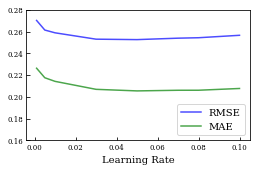

In [143]:
#plot rmse and mae with different learning rates

rmse_lr = [np.mean(lratesDic[k]['test_rmse']) for k in list(lratesDic.keys())]
mae_lr = [np.mean(lratesDic[k]['test_mae']) for k in list(lratesDic.keys())]
lr = [float(k) for k in lratesDic.keys()]

lr = np.array(lr)
rmse_lr = np.array(rmse_lr)
mae_lr = np.array(mae_lr)

lrnew = lr[lr.argsort()]
rmse_lrnew = rmse_lr[lr.argsort()]
mae_lrnew = mae_lr[lr.argsort()]

fig, ax = plt.subplots(figsize = (4, 3))
ax.plot(lrnew, rmse_lrnew, alpha = 0.7, color = "blue", label = "RMSE")
ax.plot(lrnew, mae_lrnew, alpha = 0.7,  color = "g", label = "MAE")
ax.set_xlabel('Learning Rate')
ax.tick_params(direction = "in")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.8])

ax.legend(loc='lower right')
ax.set_xticks([0, 0.020, 0.040,  0.060,  0.080, 0.100])
ax.set_yticks([0.16,0.18,0.20,0.22,0.24,0.26,0.28])
fig.savefig("LearningRatevsRmseMae_final_final.svg")
plt.show()

In [92]:
regparams = {0.05,0.07}
regparamsDic = {}

for rparam in regparams:
    algo = surprise.SVD(reg_all=rparam)
    results = cross_validate(algo, data_train, measures=['RMSE','MAE'], cv=2, verbose = True)
    regparamsDic[rparam] = results
    
f = open('continousSurprise_RegparamAnal2.txt','w')
for rparam in regparams:
    f.write(str(rparam) + '  ' + str(regparamsDic[rparam]) + '\n')
f.close()

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2599  0.2600  0.2599  0.0000  
MAE (testset)     0.2174  0.2174  0.2174  0.0000  
Fit time          62.48   61.78   62.13   0.35    
Test time         15.76   14.01   14.88   0.87    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2598  0.2599  0.2598  0.0000  
MAE (testset)     0.2177  0.2178  0.2178  0.0000  
Fit time          61.93   65.78   63.86   1.93    
Test time         18.35   15.19   16.77   1.58    


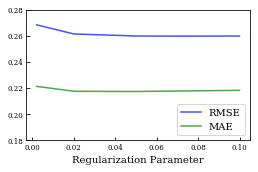

In [145]:
rmse_regpar = [np.mean(regparamsDic[k]['test_rmse']) for k in list(regparamsDic.keys())]
mae_regpar = [np.mean(regparamsDic[k]['test_mae']) for k in list(regparamsDic.keys())]
regpar = [float(k) for k in regparamsDic.keys()]


regpar = np.array(regpar)
rmse_regpar = np.array(rmse_regpar)
mae_regpar = np.array(mae_regpar)

regparnew = regpar[regpar.argsort()]
rmse_regparnew = rmse_regpar[regpar.argsort()]
mae_regparnew = mae_regpar[regpar.argsort()]


fig, ax = plt.subplots(figsize = (4, 3))
ax.plot(regparnew, rmse_regparnew, alpha = 0.7, color = "blue", label = "RMSE")
ax.plot(regparnew, mae_regparnew, alpha = 0.7,  color = "g", label = "MAE")
ax.set_xlabel('Regularization Parameter')
ax.tick_params(direction = "in")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.8])

ax.legend(loc='lower right')
ax.set_yticks([0.18,0.20, 0.22, 0.24, 0.26,0.28])
fig.savefig("RegParametervsRmseMae_final_final.svg")
plt.show()

In [97]:
epochs_list = {10,200,500,1000,150,200}

epochDic = {}

for epoch in epochs_list:
    algo = surprise.SVD(n_epochs=epoch,  reg_all= 0.05, n_factors = 10)
    results = cross_validate(algo, data_train, measures=['RMSE','MAE'], cv=2, verbose = True, return_train_measures=True)
    epochDic[epoch] = results    
    
f = open('continousSurprise_epochanal4.txt','w')
for epoch in epochs_list:
    f.write(str(epoch) + '  ' + str(epochDic[epoch]) + '\n')
f.close()

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2575  0.2577  0.2576  0.0001  
MAE (testset)     0.2142  0.2145  0.2144  0.0001  
RMSE (trainset)   0.2523  0.2524  0.2523  0.0000  
MAE (trainset)    0.2099  0.2100  0.2100  0.0000  
Fit time          218.10  225.68  221.89  3.79    
Test time         14.91   13.31   14.11   0.80    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2579  0.2574  0.2577  0.0002  
MAE (testset)     0.2148  0.2143  0.2145  0.0002  
RMSE (trainset)   0.2523  0.2529  0.2526  0.0003  
MAE (trainset)    0.2099  0.2105  0.2102  0.0003  
Fit time          170.51  169.48  170.00  0.51    
Test time         17.49   15.56   16.52   0.96    


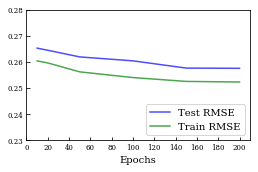

In [147]:
rmse_epoch_test = [np.mean(epochDic[k]['test_rmse']) for k in list(epochDic.keys())]
rmse_epoch_train = [np.mean(epochDic[k]['train_rmse']) for k in list(epochDic.keys())]

epoch = [int(k) for k in epochDic.keys()]

epoch = np.array(epoch)
rmse_epoch_test = np.array(rmse_epoch_test)
rmse_epoch_train = np.array(rmse_epoch_train)

epochnew = epoch[epoch.argsort()]
rmse_epochtest_new = rmse_epoch_test[epoch.argsort()]
rmse_epochtrain_new = rmse_epoch_train[epoch.argsort()]

fig, ax = plt.subplots(figsize = (4, 3))
ax.plot(epochnew, rmse_epochtest_new,  alpha = 0.7,  color = "blue", label = "Test RMSE")
ax.plot(epochnew, rmse_epochtrain_new,  alpha = 0.7,  color = "g", label = "Train RMSE")
ax.set_xlabel('Epochs')
ax.tick_params(direction = "in")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.8])

ax.legend(loc='lower right')
ax.set_xticks([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
ax.set_yticks([ 0.23, 0.24, 0.25, 0.26,0.27, 0.28])
fig.savefig("EpochvsRmseMae_final_final.svg")
plt.show()